## My Goal
I have wanted to build a machine learning project about classifying MRI sequences, because sometimes a specific sequence (for example T2) can be more adequate, for example, a segmentation problem in respect of a research domain. On the other hand, some brain tissues or organs can be visualized in some specific sequence [2].


I have used the following methods.

* I used a custom CNN architecture,
* Splitted train(3582 images) and test set (896 images),
* 5 Kfold cross-validation,
* Used tf.data for input pipeline,

## CNN Model
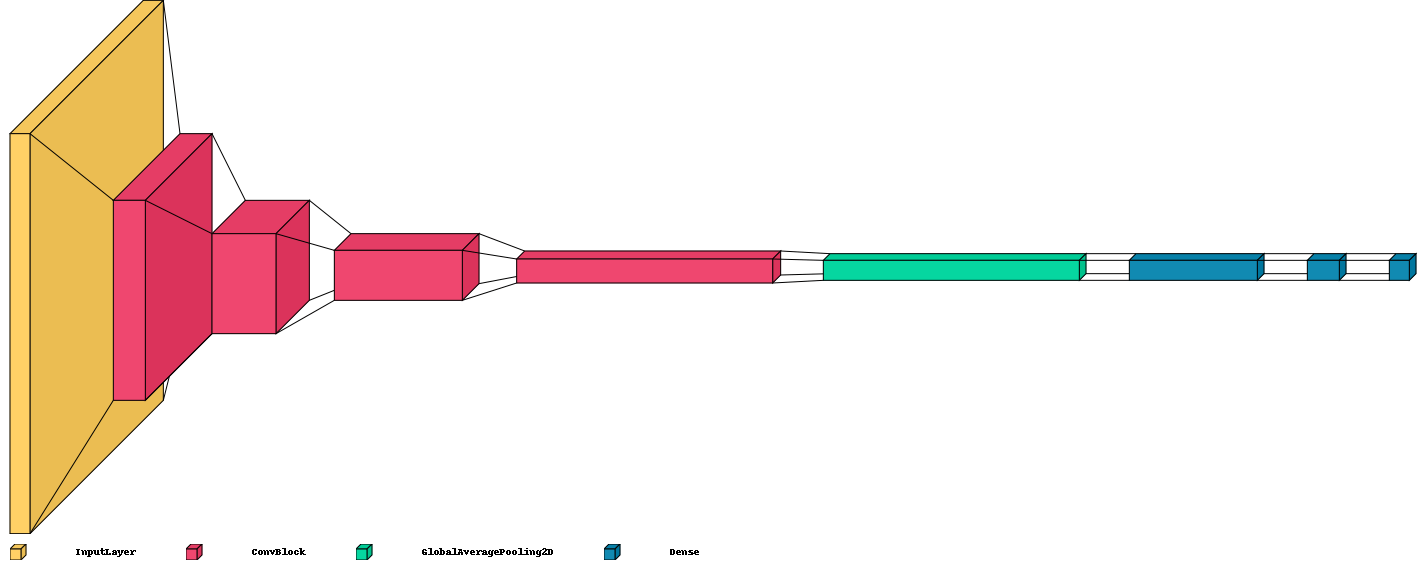


## My Another Projects
* [Rice Classification w/Custom ResNet50 (ACC 85%)](https://www.kaggle.com/code/banddaniel/rice-classification-w-custom-resnet50-acc-85)
* [Lung Segmentation UNet w/SeparableConv (Dice:0.93)](https://www.kaggle.com/code/banddaniel/lung-segmentation-unet-w-separableconv-dice-0-93)
* [Plate Detection w/detectron2 (mAP@75: 89.19)](https://www.kaggle.com/code/banddaniel/plate-detection-w-detectron2-map-75-89-19)


## References
1. https://radiopaedia.org/articles/mri-sequences-overview
2.https://www.weizmann.ac.il/chembiophys/assaf_tal/sites/chemphys.assaf_tal/files/uploads/lecture_8_-_t1_t2_modeling.pdf

In [1]:
# Importing dependencies

from IPython.display import clear_output
!pip install visualkeras
clear_output()

In [2]:
# Importing dependencies

import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import visualkeras

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

import tensorflow as tf
from tensorflow.keras.layers import Layer,Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten
from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.models import Model


SEED = 5
IMG_SIZE = 200, 200
BATCH = 128
EPOCHS = 40

# <span style="color:#e74c3c;"> Preprocessing </span>


In [3]:
# Splitting folders

folders = sorted(os.listdir('/kaggle/input/brain-tumor-mri-images-44c'))

t1_folders = []
t1c_folders = []
t2_folders = []

for i in range(len(folders)):
    if folders[i][-2:] == 'T1':
        t1_folders.append(folders[i])
    elif folders[i][-2:] == 'T2':
        t2_folders.append(folders[i])
    elif folders[i][-4:] == 'T1C+':
        t1c_folders.append(folders[i])
    else:
        pass
    
print('total T1 sequence folders -> ', len(t1_folders))
print('total T1C+ sequence folders -> ', len(t1c_folders))
print('total T2 sequence folders -> ', len(t2_folders))

total T1 sequence folders ->  15
total T1C+ sequence folders ->  14
total T2 sequence folders ->  15


In [4]:
def create_images_list(main_path, folder_names):
    full_path = []
    for x in range(len(folder_names)):
        images = os.listdir(os.path.join(main_path, folder_names[x]))
        for i in images:
            full_path.append(os.path.join(os.path.join(main_path, folder_names[x]), i))

    return full_path


t1_images = create_images_list("/kaggle/input/brain-tumor-mri-images-44c", t1_folders)
t1c_images = create_images_list("/kaggle/input/brain-tumor-mri-images-44c", t1c_folders)
t2_images = create_images_list("/kaggle/input/brain-tumor-mri-images-44c", t2_folders)

# look-up table
classes = {0:'t1', 1 : 't1_c+', 2: 't2'}

data = pd.concat([ pd.DataFrame({'img': t1_images, 'label': 0}),
                  pd.DataFrame({'img': t1c_images, 'label': 1}),
                  pd.DataFrame({'img': t2_images, 'label': 2})], ignore_index = True)

data = data.drop([1470], axis = 0) # for deleting one .webp image 
data = shuffle(data, random_state = SEED).reset_index(drop = True)

In [5]:
# a function for tf.data pipeline
# image reading -> resizing -> normalizing

def img_preprocessing(image, label):
    img = tf.io.read_file(image)
    img = tf.io.decode_jpeg(img, channels = 1)
    img = tf.image.resize(img, size = (IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    
    return img, label

# <span style="color:#e74c3c;"> Custom </span> Convolution Block


In [6]:
# Creating a convolution block class

class ConvBlock(Layer):
    def __init__(self, filters, kernel_size, activation = 'relu', batch_norm = False, **kwargs):
        super(ConvBlock, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.activation = activation
        self.batch_norm = batch_norm
        
        self.conv = Conv2D(filters, kernel_size, strides = 1, padding = 'same')
        self.batch = BatchNormalization()
        self.act = Activation(activation)
        self.pool = MaxPooling2D()
    
    
    def call(self, inputs):
        X = self.conv(inputs)
        if self.batch_norm:
            X = self.batch(X)
            X = self.act(X)
            X = self.pool(X)
            return X
        else:
            X = self.act(X)
            X = self.pool(X)
            return X
        
  
    def get_config():
        base_config = super().get_config()
        
        
        return {
            **base_config,
            "filters" : self.filters,
            "kernel_size": self.kernel_size,
            "activation" : self.act
        }


# <span style="color:#e74c3c;"> CNN </span> Model


In [7]:
inp = Input(shape = (*IMG_SIZE, 1))
C = ConvBlock(32, 2, activation = 'relu', batch_norm =True, name = 'CONV_BLOCK_1')(inp)
C = ConvBlock(64, 2, activation = 'relu', batch_norm =True, name = 'CONV_BLOCK_2')(C)
C = ConvBlock(128, 2, activation = 'relu', batch_norm =True, name = 'CONV_BLOCK_3')(C)
C = ConvBlock(256, 2, activation = 'relu', batch_norm =True, name = 'CONV_BLOCK_4')(C)

C = GlobalAveragePooling2D()(C)
C = Dense(128, activation = 'relu')(C)
C = Dense(32, activation = 'relu')(C)
out = Dense(3, activation = 'softmax')(C)

model = Model(inputs = inp, outputs = out)
model.summary()

model.compile(optimizer = tf.keras.optimizers.Adam() , loss = 'sparse_categorical_crossentropy', metrics = ['acc'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 1)]     0         
                                                                 
 CONV_BLOCK_1 (ConvBlock)    (None, 100, 100, 32)      288       
                                                                 
 CONV_BLOCK_2 (ConvBlock)    (None, 50, 50, 64)        8512      
                                                                 
 CONV_BLOCK_3 (ConvBlock)    (None, 25, 25, 128)       33408     
                                                                 
 CONV_BLOCK_4 (ConvBlock)    (None, 12, 12, 256)       132352    
                                                                 
 global_average_pooling2d (G  (None, 256)              0         
 lobalAveragePooling2D)                                          
                                                             

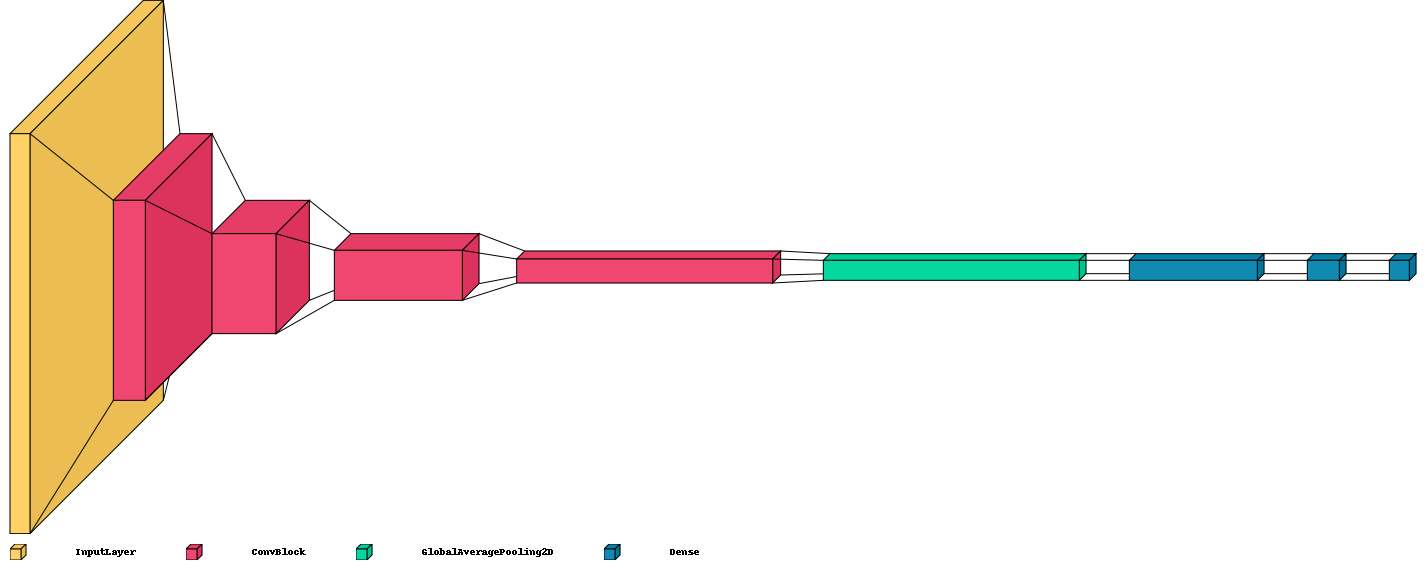

<Figure size 640x480 with 0 Axes>

In [8]:
#Plotting the model

plt.figure(dpi = 100)
visualkeras.layered_view(model, spacing = 50,  scale_z = 1, scale_xy = 2 , legend=True,
                         type_ignore=[BatchNormalization, Flatten, Activation, MaxPooling2D])

# <span style="color:#e74c3c;"> Training </span> 


In [9]:
fold_hists = []
test_evals = []
test_f1_scores = []
test_precision_scores = []
test_recall_scores = []
    
    
kf = KFold(n_splits = 5, shuffle = True, random_state = SEED)
    
for i, (train_index, test_index) in enumerate(kf.split(data['img'],  data['label'])):
    
    print('~'*75)
    print(str(i+1) + '.fold starting')

    X_train_fold = data['img'][train_index]
    y_train_fold = data['label'][train_index]
    
    X_test_fold = data['img'][test_index]
    y_test_fold = data['label'][test_index]
    
    # Creating tf.pipeline
    train_loader = tf.data.Dataset.from_tensor_slices((X_train_fold, y_train_fold))
    train_dataset = (train_loader
                     .map(img_preprocessing)
                     .batch(BATCH)
                     .prefetch(BATCH))
    
    test_loader = tf.data.Dataset.from_tensor_slices((X_test_fold, y_test_fold))
    test_dataset = (test_loader
                    .map(img_preprocessing)
                    .batch(BATCH)
                    .prefetch(BATCH))
    
    # Training
    hist = model.fit(train_dataset, epochs = EPOCHS, batch_size = BATCH, verbose = 0)
    fold_hists.append(hist)
    
    # Test evaluation
    test_eval = model.evaluate(test_dataset, verbose = 0)
    test_evals.append(test_eval)
    
    # Test set prediction
    test_take1 =  test_dataset.take(-1)
    test_take1_ = list(test_take1)
    pred = model.predict(test_take1)
    pred = np.argmax(pred, axis = 1)
    
    # Classification metrics
    test_precision = precision_score(y_test_fold, pred, average = 'weighted')
    test_recall = recall_score(y_test_fold, pred, average = 'weighted')
    test_f1 = f1_score(y_test_fold, pred, average = 'weighted')
    test_accuracy_score = accuracy_score(y_test_fold, pred)
    
    test_precision_scores.append(test_precision)
    test_recall_scores.append(test_recall)
    test_f1_scores.append(test_f1)

    print('Test precision {0:.5f}'.format(test_precision))
    print('Test recall {0:.5f}'.format(test_recall))
    print('Test F1 Score {0:.5f}'.format(test_f1))
    print('Test Accuracy {0:.3f} %'.format(test_accuracy_score * 100))

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
1.fold starting
7/7 [==============================] - 4s 501ms/step
Test precision 0.82648
Test recall 0.74219
Test F1 Score 0.74064
Test Accuracy 74.219 %
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2.fold starting
7/7 [==============================] - 1s 203ms/step
Test precision 0.93669
Test recall 0.92857
Test F1 Score 0.92731
Test Accuracy 92.857 %
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
3.fold starting
7/7 [==============================] - 1s 178ms/step
Test precision 0.99229
Test recall 0.99219
Test F1 Score 0.99220
Test Accuracy 99.219 %
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
4.fold starting
7/7 [==============================] - 1s 179ms/step
Test precision 0.99119
Test recall 0.99106
Test F1 Score 0.99104
Test Accuracy 99.106 %
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# <span style="color:#e74c3c;"> Training </span> Results


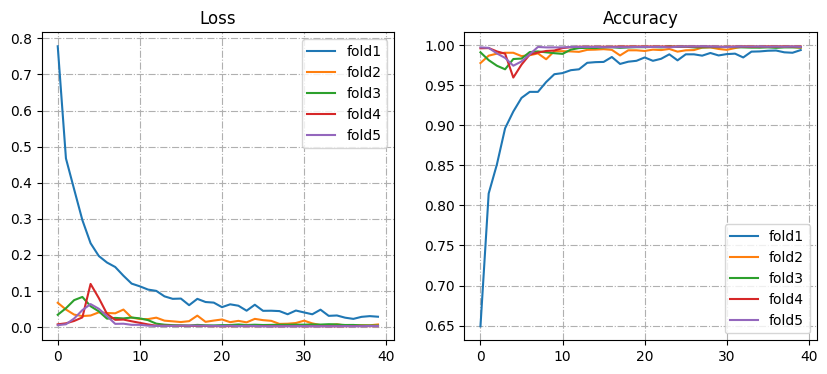

In [10]:
fig, axs = plt.subplots(1,2, figsize = (10,4), dpi = 100)

axs[0].grid(linestyle="dashdot")
axs[0].set_title("Loss")
axs[0].plot(fold_hists[0].history['loss'])
axs[0].plot(fold_hists[1].history['loss'])
axs[0].plot(fold_hists[2].history['loss'])
axs[0].plot(fold_hists[3].history['loss'])
axs[0].plot(fold_hists[4].history['loss'])
axs[0].legend(["fold1", "fold2", "fold3", "fold4", "fold5"])

axs[1].grid(linestyle="dashdot")
axs[1].set_title("Accuracy")
axs[1].plot(fold_hists[0].history['acc'])
axs[1].plot(fold_hists[1].history['acc'])
axs[1].plot(fold_hists[2].history['acc'])
axs[1].plot(fold_hists[3].history['acc'])
axs[1].plot(fold_hists[4].history['acc'])
axs[1].legend(["fold1", "fold2", "fold3", "fold4", "fold5"])
     

# <span style="color:#e74c3c;"> Test </span> Results


In [11]:
test_evals_loss = []
test_evals_acc = []

for i in range(len(test_evals)):
    test_evals_loss.append(test_evals[i][0])
    test_evals_acc.append(test_evals[i][1]*100)

In [12]:
results = pd.DataFrame({'test_recall_score': test_recall_scores, 'test_precision_score' : test_precision_scores,
                        'test_f1_scores': test_f1_scores, 'test_evals_loss':test_evals_loss, 'test_evals_acc':test_evals_acc  })

results.index = ['fold 1', 'fold 2', 'fold 3', 'fold 4', 'fold 5']

In [13]:
results

,test_recall_score,test_precision_score,test_f1_scores,test_evals_loss,test_evals_acc
fold 1,0.742188,0.826480,0.740644,1.214037,74.218750
fold 2,0.928571,0.936685,0.927311,0.244886,92.857140
fold 3,0.992188,0.992285,0.992199,0.015924,99.218750
fold 4,0.991061,0.991195,0.991042,0.029448,99.106145
fold 5,0.992179,0.992218,0.992186,0.023538,99.217880
